Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

In [5]:
model_name = 'sklearn-iris-model'
model_version = '1'
endpoint_name = "sklearn-iris-batch-endpoint"
deployment_name = "blue"
compute_name = "batch-cluster"

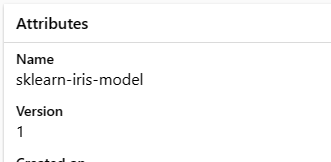

Classes ModelBatchDeployment and PipelineComponentBatchDeployment were introduced in version 1.7.0 of the SDK. 

Use ```pip install -U azure-ai-ml``` to get the last version of it.

In [6]:
# !pip install -U azure-ai-ml

In [8]:
from azure.ai.ml import MLClient, Input
from azure.ai.ml.entities import (
    BatchEndpoint, 
    ModelBatchDeployment, 
    ModelBatchDeploymentSettings, 
    PipelineComponentBatchDeployment, 
    Model, 
    AmlCompute, 
    Data, 
    BatchRetrySettings, 
    CodeConfiguration, 
    Environment, 
    Data
)
from azure.ai.ml.constants import AssetTypes, BatchDeploymentOutputAction
from azure.ai.ml.dsl import pipeline
from azure.identity import DefaultAzureCredential
import datetime
import pandas as pd
from dotenv import load_dotenv
import os

In [10]:
# load enter details of your AML workspace from .env file

load_dotenv()

subscription_id = os.environ.get("subscription_id")
resource_group = os.environ.get("resource_group")
workspace = os.environ.get("workspace")

# get a handle to the workspace
ml_client = MLClient(
    DefaultAzureCredential(), 
    subscription_id=subscription_id,
    resource_group_name=resource_group,
    workspace_name=workspace
)

# Deploy an MLflow model to an Batch endpoint



Batch Endpoint can only deploy registered models. In this case, we already have a local copy of the model in the repository, so we only need to publish the model to the registry in the workspace. You can skip this step if the model you are trying to deploy is already registered.

In [12]:
# get model
model = ml_client.models.get(model_name, version=model_version)

Before moving any forward, we need to make sure the batch deployments we are about to create can run on some infrastructure (compute). Batch deployments can run on any Azure Machine Learning compute that already exists in the workspace. That means that multiple batch deployments can share the same compute infrastructure. In this example, we are going to work on an Azure Machine Learning compute cluster called cpu-cluster. Let's verify the compute exists on the workspace or create it otherwise.

In [13]:

if not any(filter(lambda m: m.name == compute_name, ml_client.compute.list())):
    compute_cluster = AmlCompute(
        name=compute_name, description="amlcompute", min_instances=0, max_instances=5
    )
    ml_client.begin_create_or_update(compute_cluster).result()

Now it is time to create the batch endpoint and deployment. Let's start with the endpoint first. Endpoints only require a name and a description to be created. The name of the endpoint will end-up in the URI associated with your endpoint. Because of that, batch endpoint names need to be unique within an Azure region. For example, there can be only one batch endpoint with the name mybatchendpoint in westus2.

In [14]:
endpoint = BatchEndpoint(
    name=endpoint_name,
    description="Batch endpoint for batch scoring",
    tags={"stage": "dev"},
)
    
# Let's create the endpoint:
ml_client.batch_endpoints.begin_create_or_update(endpoint).result()


Now, let create the deployment. MLflow models don't require you to indicate an environment or a scoring script when creating the deployments as it is created for you. However, you can specify them if you want to customize how the deployment does inference.

In [17]:
deployment = ModelBatchDeployment(
    name="classifier-svm",
    description="A iris condition classifier based on SVM",
    endpoint_name=endpoint.name,
    model=model,
    compute=compute_name,
    settings=ModelBatchDeploymentSettings(
        instance_count=2,
        max_concurrency_per_instance=2,
        mini_batch_size=10,
        output_action=BatchDeploymentOutputAction.APPEND_ROW,
        output_file_name="predictions.csv",
        retry_settings=BatchRetrySettings(max_retries=3, timeout=300),
        logging_level="info",
    ),
)

# Let's create the deployment

ml_client.batch_deployments.begin_create_or_update(deployment).result()

Class ModelBatchDeploymentSettings: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class ModelBatchDeployment: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.


BatchDeployment({'provisioning_state': 'Succeeded', 'endpoint_name': 'sklearn-iris-batch-endpoint', 'type': None, 'name': 'classifier-xgboost', 'description': 'A heart condition classifier based on XGBoost', 'tags': {}, 'properties': {}, 'print_as_yaml': True, 'id': '/subscriptions/f804f2da-c27b-45ac-bf80-16d4d331776d/resourceGroups/rg-mlopsv2clas-505prod/providers/Microsoft.MachineLearningServices/workspaces/mlw-mlopsv2clas-505prod/batchEndpoints/sklearn-iris-batch-endpoint/deployments/classifier-xgboost', 'Resource__source_path': None, 'base_path': '/mnt/batch/tasks/shared/LS_root/mounts/clusters/alibina8/code/dstoolkit-mlops-v2/notebooks', 'creation_context': <azure.ai.ml.entities._system_data.SystemData object at 0x7f8b2b985690>, 'serialize': <msrest.serialization.Serializer object at 0x7f8b2b984370>, 'model': '/subscriptions/f804f2da-c27b-45ac-bf80-16d4d331776d/resourceGroups/rg-mlopsv2clas-505prod/providers/Microsoft.MachineLearningServices/workspaces/mlw-mlopsv2clas-505prod/mode

Although you can invoke a specific deployment inside of an endpoint, you will usually want to invoke the endpoint itself and let the endpoint decide which deployment to use. Such deployment is named the "default" deployment. This gives you the possibility of changing the default deployment and hence changing the model serving the deployment without changing the contract with the user invoking the endpoint. Use the following instruction to update the default deployment:

In [18]:
endpoint = ml_client.batch_endpoints.get(endpoint.name)
endpoint.defaults.deployment_name = deployment.name
ml_client.batch_endpoints.begin_create_or_update(endpoint).result()

## Deployment could take few minutes to complete. Please wait...

# Test deployment

In [3]:
# create dataset to score

import pandas as pd
from sklearn.datasets import load_iris

# load the iris dataset
iris = load_iris()

# create a DataFrame with the iris data
df = pd.DataFrame(iris.data, columns=iris.feature_names)

# write the DataFrame to a CSV file
for i in range(10):
    df.iloc[i:i+1].to_csv(f'./test/iris_{i}.csv', index=False)


In [11]:
# let create a data asset for the batch scoring

data_path = "test"
dataset_name = "iris-dataset-unlabeled"

iris_dataset_unlabeled = Data(
    path=data_path,
    type=AssetTypes.URI_FOLDER,
    description="An unlabeled dataset for iris classification",
    name=dataset_name,
)

ml_client.data.create_or_update(iris_dataset_unlabeled)

Uploading test (0.0 MBs): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 860/860 [00:00<00:00, 13919.35it/s]


Data({'skip_validation': False, 'mltable_schema_url': None, 'referenced_uris': None, 'type': 'uri_folder', 'is_anonymous': False, 'auto_increment_version': False, 'auto_delete_setting': None, 'name': 'iris-dataset-unlabeled', 'description': 'An unlabeled dataset for iris classification', 'tags': {}, 'properties': {}, 'print_as_yaml': True, 'id': '/subscriptions/f804f2da-c27b-45ac-bf80-16d4d331776d/resourceGroups/rg-mlopsv2clas-505prod/providers/Microsoft.MachineLearningServices/workspaces/mlw-mlopsv2clas-505prod/data/iris-dataset-unlabeled/versions/2', 'Resource__source_path': None, 'base_path': '/mnt/batch/tasks/shared/LS_root/mounts/clusters/alibina8/code/dstoolkit-mlops-v2/notebooks', 'creation_context': <azure.ai.ml.entities._system_data.SystemData object at 0x7f4a81bc7eb0>, 'serialize': <msrest.serialization.Serializer object at 0x7f4a81bc7e80>, 'version': '2', 'latest_version': None, 'path': 'azureml://subscriptions/f804f2da-c27b-45ac-bf80-16d4d331776d/resourcegroups/rg-mlopsv2cl

In [12]:
# let refresh the data
iris_dataset_unlabeled = ml_client.data.get(name=dataset_name, label="latest")

In [14]:
input = Input(type=AssetTypes.URI_FOLDER, path=iris_dataset_unlabeled.id)

job = ml_client.batch_endpoints.invoke(endpoint_name=endpoint_name, input=input)

In [15]:
ml_client.jobs.get(job.name)

Experiment,Name,Type,Status,Details Page
sklearn-iris-batch-endpoint,batchjob-04d4a850-4bd7-4058-9288-f2d070b50075,pipeline,Running,Link to Azure Machine Learning studio


## download the results

In [25]:
# You can download the results of the job by using the job name, when the job is completed.
import time

status = ml_client.jobs.get(job.name).status

while status != "Completed":
    status = ml_client.jobs.get(job.name).status
    print("Job status: ", status)
    time.sleep(30)


ml_client.jobs.download(name=job.name, download_path=".", output_name="score")

In [26]:
from ast import literal_eval


# Once the file is downloaded, you can open it using your favorite tool. The following example loads the predictions using Pandas dataframe.
with open("./predictions.csv", "r") as f:
    data = f.read()
    score = pd.DataFrame(
        literal_eval(data.replace("\n", ",")), columns=["file", "prediction"]
    )
score

,file,prediction
0,iris_0.csv,setosa
1,iris_1.csv,setosa
2,iris_2.csv,setosa
3,iris_3.csv,setosa
4,iris_4.csv,setosa
5,iris_5.csv,setosa
6,iris_6.csv,setosa
7,iris_7.csv,setosa
8,iris_8.csv,setosa
9,iris_9.csv,setosa
